## 7.4 GoogLeNet
在2014年的ImageNet图像识别挑战赛中，一个名叫GoogLeNet (Szegedy et al., 2015)的网络架构大放异彩。 GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。 这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。 毕竟，以前流行的网络使用小到$1 \times 1$，大到 $11 \times 11$的卷积核。 本文的一个观点是，有时使用不同大小的卷积核组合是有利的。 本节将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，现在有了更好的训练方法，这些特性不是必要的。

### 7.4.1 Inception块
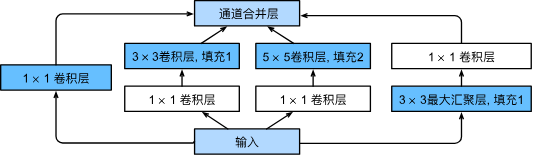  
Inception块由四条并行路径组成。 前三条路径使用窗口大小为$1 \times 1$、$3 \times 3$和$5 \times 5$的卷积层，从不同空间大小中提取信息。 中间的两条路径在输入上执行$1 \times 1$卷积，以减少通道数，从而降低模型的复杂性。 第四条路径使用$3 \times 3$最大汇聚层，然后使用$1 \times 1$卷积层来改变通道数。 这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

c:\Users\yy200\miniconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### 7.4.2. GoogLeNet模型
GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。 第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。<br>
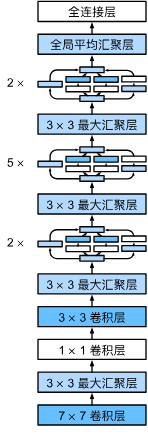
接下来逐一实现GoogLeNet的每个模块。

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [9]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [10]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


### 7.4.3. 训练模型

loss 0.251, train acc 0.904, test acc 0.882
1992.7 examples/sec on cuda:0


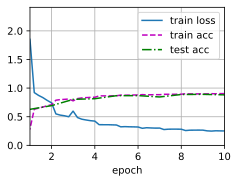

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 7.4.5 练习题解答

#### 1. GoogLeNet后续版本实现分析

1. ​**批量规范化层（Batch Normalization）​**  
   - ​**作用**：通过标准化网络激活值加速训练，公式为：  
     $\hat{x}^{(k)} = \frac{x^{(k)} - E[x^{(k)}]}{\sqrt{Var[x^{(k)}] + \epsilon}}$  
   - ​**实现**：在每个Inception模块后插入BN层（Ioffe & Szegedy, 2015）

2. ​**Inception模块调整**  
   - ​**改进**：采用更宽（通道数↑）但更浅的结构（Szegedy et al., 2016），典型分支：  
     - 分支1：$1\times1$卷积  
     - 分支2：$1\times1$卷积 → $3\times3$卷积  
     - 分支3：$1\times1$卷积 → $5\times5$卷积  
     - 分支4：$3\times3$最大池化 → $1\times1$卷积

3. ​**标签平滑（Label Smoothing）​**  
   - ​**公式**：将硬标签$y$转换为平滑标签$\hat{y}$：  
     $\hat{y}_i = (1-\epsilon)y_i + \frac{\epsilon}{K}\quad(K为类别数)$  
   - ​**作用**：防止模型对训练样本过拟合（$\epsilon=0.1$为典型值）

4. ​**残差连接（Residual Connection）​**  
   - ​**实现**：跨Inception模块添加跳跃连接（Szegedy et al., 2017）：  
     $H(x) = F(x) + x$  
   - ​**优势**：缓解梯度消失，允许训练更深的网络

---

#### 2. GoogLeNet的最小图像尺寸

**推导过程**：  
1. ​**初始层**：  
   - $7\times7$卷积（stride=2）→ 输出尺寸缩减为$\lfloor\frac{W-7}{2}+1\rfloor$  
   - $3\times3$最大池化（stride=2）→ 尺寸再减半  
2. ​**Inception模块堆叠**：  
   经历4次步长为2的下采样（含2个池化层和2个卷积层）  
3. ​**最终约束**：  
   要求所有Inception模块输出尺寸≥$1\times1$  

**计算结论**：  
总下采样次数为$2^5=32$，故最小输入尺寸为$\boxed{32\times32}$

---

#### 3. 模型参数对比与压缩原理

**参数规模对比**：  
| 网络      | 参数量      | 核心差异                  |
|-----------|-------------|--------------------------|
| AlexNet   | ~60 million | 全连接层占比89%          |
| VGG-16    | ~138 million| 小卷积核堆叠+全连接层     |
| NiN       | ~1 million  | 全局平均池化替代全连接层  |
| GoogLeNet | ~6 million  | 1×1卷积降维+并行结构      |

**参数压缩原理**：  
1. ​**NiN网络**：  
   - ​**全局平均池化**​（GAP）消除全连接参数：  
     $参数量_{全连接} = C_{in}×C_{out} → 参数量_{GAP}=0$  
   - ​**1×1卷积**跨通道压缩：  
     $参数量_{1×1} = C_{in}×1×1×C_{out} \quad (远小于3×3卷积)$

2. ​**GoogLeNet**：  
   - ​**Inception并行结构**分散参数负载：  
     $参数量_{总} = \sum_{i=1}^4 参数量_{分支i}$  
   - ​**辅助分类器**仅在训练时引入额外参数（推理时移除）